In [7]:
# model.py
import random
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector

class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1
    
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
             
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1     
        
    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()
    
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)
        
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = SingleGrid(width, height, True)
        self.schedule = RandomActivation(self)
        
        # Create agents
        for i in range(self.num_agents):
            pos = self.grid.find_empty()
            a = MoneyAgent(i, self)
            print(pos)
            self.grid.place_agent(a, pos)
            #self.schedule.add(a)
            
#             for i in range(self.number_of_bug):
#             pos = self.grid.find_empty()
#             bug = Bug(i, self)
#             bug.strategy = self.strategy
#             self.grid.place_agent(bug, pos)
#             self.schedule.add(bug)
            
#             # Add the agent to a random grid cell
#             x = random.randrange(self.grid.width)
#             y = random.randrange(self.grid.height)
#             self.grid.place_agent(a,(x,y))
            
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": lambda a: a.wealth})
        
    def step (self):
        """Advance the model by one step."""
        self.datacollector.collect(self)
        self.schedule.step()

# run.py
# all_wealth = []
# for j in range(100):
    # Run the model
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()
    
#     # Store the results
#     for agent in model.schedule.agents:
#         all_wealth.append(agent.wealth)
    
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

plt.show()

gini = model.datacollector.get_model_vars_dataframe()
gini.plot()
plt.show()

agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))
plt.show()

one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()
plt.show()
# agent_wealth = [a.wealth for a in model.schedule.agents]
# plt.hist(all_wealth, bins=range(max(all_wealth)+1))
# plt.show()

(1, 6)
(3, 0)
(7, 6)
(5, 5)
(0, 6)
(8, 0)
(5, 6)
(5, 3)
(9, 0)
(2, 3)
(5, 7)
(2, 4)
(6, 7)
(1, 7)
(9, 7)
(3, 3)
(7, 2)
(0, 5)
(2, 5)
(2, 1)
(5, 9)
(8, 5)
(8, 1)
(7, 7)
(4, 6)
(3, 6)
(1, 3)
(5, 4)
(4, 4)
(7, 4)
(5, 0)
(8, 9)
(1, 4)
(8, 4)
(3, 1)
(9, 8)
(9, 2)
(5, 2)
(8, 2)
(1, 1)
(7, 5)
(6, 8)
(6, 0)
(8, 8)
(8, 3)
(4, 7)
(3, 4)
(2, 7)
(4, 9)
(0, 4)


ZeroDivisionError: division by zero

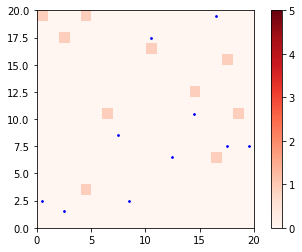

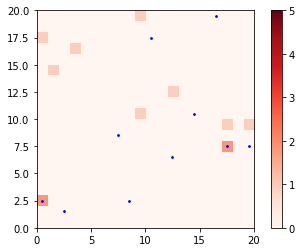

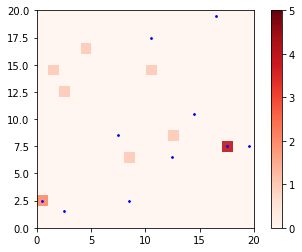

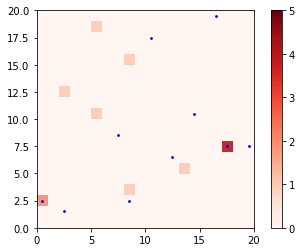

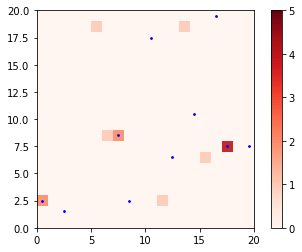

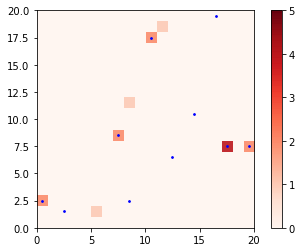

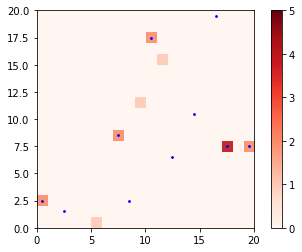

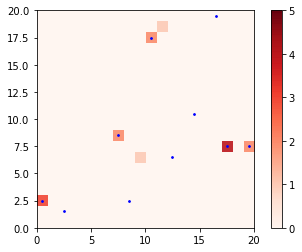

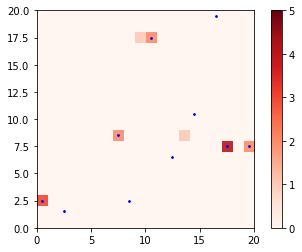

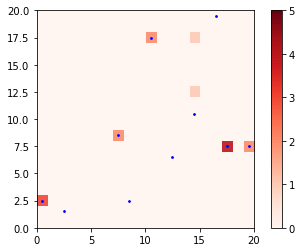

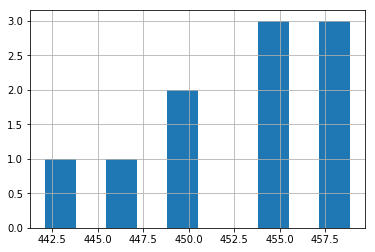

In [239]:
# Now for EV's
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.space import ContinuousSpace
from mesa.datacollection import DataCollector
from scipy.spatial import distance


iterations = 10
max_sockets = 2
n_poles = 10
n_EVs = 10

# Create the model
class EV_Model(Model):
    def __init__(self, N, width, height, n_poles):
        self.num_agents = N
        self.grid = MultiGrid(width, height, False) #toroidal (for now)
        self.schedule = RandomActivation(self)
        vision = 4
        
        # Create Charge Pole agents
        for i in range(n_poles):
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            charge_pole = Charge_pole(i, (x,y), self, max_sockets)
            self.grid.place_agent(charge_pole, (x, y))
        
        # Create EV agents
        for i in range(self.num_agents):
            EV = EV_Agent(i, self, vision)
            self.schedule.add(EV)
            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(EV, (x, y))
        
            
        self.datacollector = DataCollector(
            agent_reporters={"Battery": lambda EV: EV.battery})
        #self.datacollector = DataCollector(data)
            
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)

        
# Create charging pole agents
class Charge_pole(Agent):
    def __init__(self, unique_id, pos, model, max_sockets):
        super().__init__(pos, model)
        self.amount = max_sockets
        self.max_sockets = max_sockets
        self.pos = pos
        

    def step(self):
        self.amount = min([self.max_sockets, self.amount + 1])

# Create the Electric Vehicles agents
class EV_Agent(Agent):
    """ An agent with fixed initial battery."""
    def __init__(self, unique_id, model, vision):
        super().__init__(unique_id, model)
        self.vision = vision
        self.battery = 500
    
    # can randomly move in the neighbourhood with radius = vision
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            radius = self.vision,
            moore=True,
            include_center=False)
        
        # if agent can find CP it will go to that position
        if self.find_CP(self.pos):
            new_position = self.find_CP(self.pos)
        else:
            new_position = random.choice(possible_steps)
        self.use_battery(new_position)
        self.model.grid.move_agent(self, new_position)
    
    def find_CP(self, pos):
        neig = self.model.grid.get_neighbors(
            self.pos,
            radius = self.vision, 
            moore = True)
        possible_charge_poles =[]
        
        #check if there is an agent in neighborhood, and what type of agents
        if neig:
            for agent in neig:
                if isinstance(agent, Charge_pole):
                    possible_charge_poles.append(agent)
                    
        # randomly select from the CP in the neighborhood -> not perfect yet
            if possible_charge_poles:
                chosen_charge_pole = random.choice(possible_charge_poles)
                return chosen_charge_pole.pos
                
            
    # function to decrease battery with the distance
    def use_battery(self, new_position):
        dist = (distance.euclidean(self.pos, new_position))
        cost = dist
        self.battery -= cost
    
    def step(self):
        self.move()
        if self.battery > 0:
            self.move()
            #print(self.unique_id, self.battery)
        
width = 20
height = 20
# Construct EV model
model = EV_Model(n_EVs, width, height, n_poles)

# Let the model iterate
for i in range(iterations):
    #model.step()

    

    CP_counts = np.zeros((model.grid.width, model.grid.height))
    CP_counts = list([])
    EV_counts = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell

        if list(cell_content):
            for occupant in list(cell_content):
                if isinstance(occupant ,EV_Agent):
                    EV_count = len(cell_content)

                    # to get a good plot with imshow x an y are reversed: y, x
                    EV_counts[y,x] = EV_count
                    #print("EV ", x,y)
                elif isinstance(occupant,Charge_pole):
                    CP_count = len(cell_content)
                    #print("CP " , x,y)
                    #CP_counts[x][y] = CP_count
                    CP_counts.append((x,y))


    extent = 0, width, 0, height
    fig = plt.figure(frameon=False)


    im1 = plt.imshow(EV_counts, interpolation = 'nearest', cmap = 'Reds', 
                     vmin = 0, vmax = int(n_EVs/2),
                     extent = extent, alpha = 0.9, origin = 'lower')
    plt.colorbar(ticks = (np.array([0,5,10,15,20,25])/100*n_EVs*2))

    # Plot the Charge Poles
    CP_x, CP_y =  map(list, zip(*CP_counts))

    #make them in the middle of the cell
    CP_x = np.array(CP_x) + 0.5
    CP_y = np.array(CP_y) + 0.5

    im2 = plt.scatter(CP_x, CP_y, color = 'blue', s = 3)
    #im2 = plt.imshow(CP_counts, cmap = 'binary', extent = extent, alpha = 0.2)
    plt.show()
    
    model.step()


agent_battery = model.datacollector.get_agent_vars_dataframe()
end_battery = agent_battery.xs(iterations-1, level="Step")["Battery"]
end_battery.hist(bins=10)
       
   

In [220]:
# server.py
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer

# server.py
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "r": 0.5}
    if type(agent) is Charge_pole:
        portrayal["Color"] = "cornflowerblue"
    elif type(agent) is EV_Agent:
        portrayal["Color"] = "red"
    
    return portrayal

grid = CanvasGrid(agent_portrayal, 20, 20, 500, 500)

server = ModularServer(EV_Model,
                       [grid],
                       "EV Model",
                       {"N": 100, "width": 20, "height": 20, "n_poles": 10})


server.port = 8522 # The default
server.launch()

Interface starting at http://127.0.0.1:8522
Socket opened!
{"type":"get_params"}
{"type":"reset"}
{"type":"get_step","step":1}
